In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score

from catboost import CatBoostClassifier

import shap
shap.initjs()

%matplotlib inline

In [10]:
def get_y(y, n=10):
    return ((np.angle((y.x + 1j * y.y).values) + np.pi) / 2 / np.pi * 10).astype(int)

In [11]:
def acc_1(y_pred, y_true):
    return np.sum(y_pred == y_true) / len(y_true)
def acc_3(y_pred, y_true, n=10):
    return np.sum(np.logical_or(np.abs(y_pred - y_test) <= 1., np.abs(y_pred - y_test) == n-1)) / len(y_true)

In [12]:
track = pd.read_csv('data/CA1_6_1_track.csv')
track.columns = ['time', 'x', 'y']
track = track.set_index('time')
track.index = (track.index * 20).astype(np.int32)

In [13]:
neuropil = pd.read_csv('data/CA1_6_1_neuropil.csv')
neuropil.columns = list(range(len(neuropil.columns)))
neuropil = neuropil.set_index(0)
neuropil.index = (neuropil.index * 20).astype(np.int32)

In [14]:
full_data = neuropil.iloc[645:].reset_index().drop([0], axis=1).join(track, how='inner').loc[10:]

In [15]:
full_data.head()

,1,2,3,4,5,6,7,8,9,10,...,583,584,585,586,587,588,589,590,x,y
10,-0.004962,-0.007518,0.002856,-0.002459,0.012671,0.004508,-0.002190,-0.003734,-0.000925,-0.002684,...,0.001980,-0.000420,0.006400,0.007676,0.003326,0.006363,-0.001662,-0.003236,-19.161957,5.008783
11,-0.005094,-0.005817,0.003220,0.000504,0.010845,0.002914,-0.003777,-0.005426,-0.001447,-0.005684,...,0.002795,0.001087,0.004594,0.006707,0.003611,0.004232,-0.000977,-0.000709,-20.055400,5.602721
12,-0.004959,-0.007381,0.002250,-0.001745,0.010025,-0.001474,-0.003159,-0.002456,0.000444,-0.003892,...,0.002975,0.002064,0.005655,0.007591,0.003341,0.005342,-0.000768,-0.001314,-19.999324,6.323581
13,-0.004731,-0.006127,0.002409,0.000073,0.007454,0.000138,-0.003104,-0.002373,-0.001115,-0.003947,...,0.002888,0.002873,0.005268,0.007248,-0.000298,0.007396,0.000361,-0.004089,-19.921652,7.028567
14,-0.005890,-0.007438,0.003455,-0.002265,0.010671,0.002261,-0.000498,-0.002451,-0.001143,-0.002059,...,0.003474,0.004536,0.006306,0.004947,0.001629,0.007965,0.000599,-0.002331,-19.838119,7.727636


In [16]:
fine_cells = pd.read_csv('data/CA1_6_1_fine_cells.csv')
fine_cells['time'] = fine_cells['time,s\cell#']
fine_cells.drop(['time,s\cell#'], axis=1, inplace=True)
fine_cells.set_index('time', inplace=True)
fine_cells.index = (fine_cells.index * 20).astype(np.int32)

In [17]:
best_columns = fine_cells.columns.astype(int)

In [18]:
X_cols = full_data.columns[:-2]
y_cols = full_data.columns[-2:]

In [19]:
X = full_data[X_cols]
y = get_y(full_data[y_cols])

In [20]:
mis = dict()

In [21]:
for col in X.columns:
    quantiles = [X[col].quantile(q) for q in np.arange(0, 1, 0.1)]
    batches = np.zeros(len(y)).astype(int)
    for q in quantiles:
        batches += (X[col] - q >= 0)
    mis[col] = mutual_info_score(batches, y)

In [22]:
mutual_info_score(y, y) / np.log(2)

3.1136764800306898

In [23]:
for col, mi in sorted(mis.items(), key=lambda x: -x[1]):
    print(col, mi / np.log(2))

120 0.6713816329191558
147 0.6588324029449011
382 0.6197021071799993
106 0.5821128231637169
77 0.577001462733999
397 0.5512336036885923
31 0.5465369834398437
383 0.5437278391606745
274 0.5370636352812777
158 0.5328195124931109
231 0.5272478124902299
129 0.5245196558730867
462 0.5241538908367942
154 0.5225330521499056
119 0.509896373243915
71 0.508895777950438
133 0.5073148638464373
344 0.5028826356615305
251 0.4983063754189065
93 0.487974812612755
391 0.48716938230592255
198 0.481886792819624
137 0.4717588100143141
247 0.4699233427235205
39 0.4671349664542284
405 0.46704140873798317
376 0.459096176263624
124 0.45879839853464605
227 0.45722770558886006
140 0.4510877588308909
171 0.4479116091340768
223 0.4420314209260226
232 0.4412914493414732
567 0.4360567394444467
557 0.43591711833056807
15 0.43565630719684273
316 0.43307491161027983
363 0.4234942498788937
193 0.4208905319196743
111 0.41870750175766597
378 0.41859693686306737
330 0.417910093303597
144 0.4156876555946284
108 0.414239737

In [24]:
cols = [col for col, _ in sorted(mis.items(), key=lambda x: -x[1])][:20]

In [25]:
worst_cols = [col for col, _ in sorted(mis.items(), key=lambda x: x[1])][:20]

In [26]:
best_columns

Int64Index([  4,  69,  92, 116, 123, 128, 136, 143, 147, 153, 161, 165, 170,
            176, 188, 192, 208, 231, 273, 354, 408, 543, 570, 577],
           dtype='int64')

In [27]:
set(cols).intersection(set(best_columns + 1))

{93, 129, 154, 274}

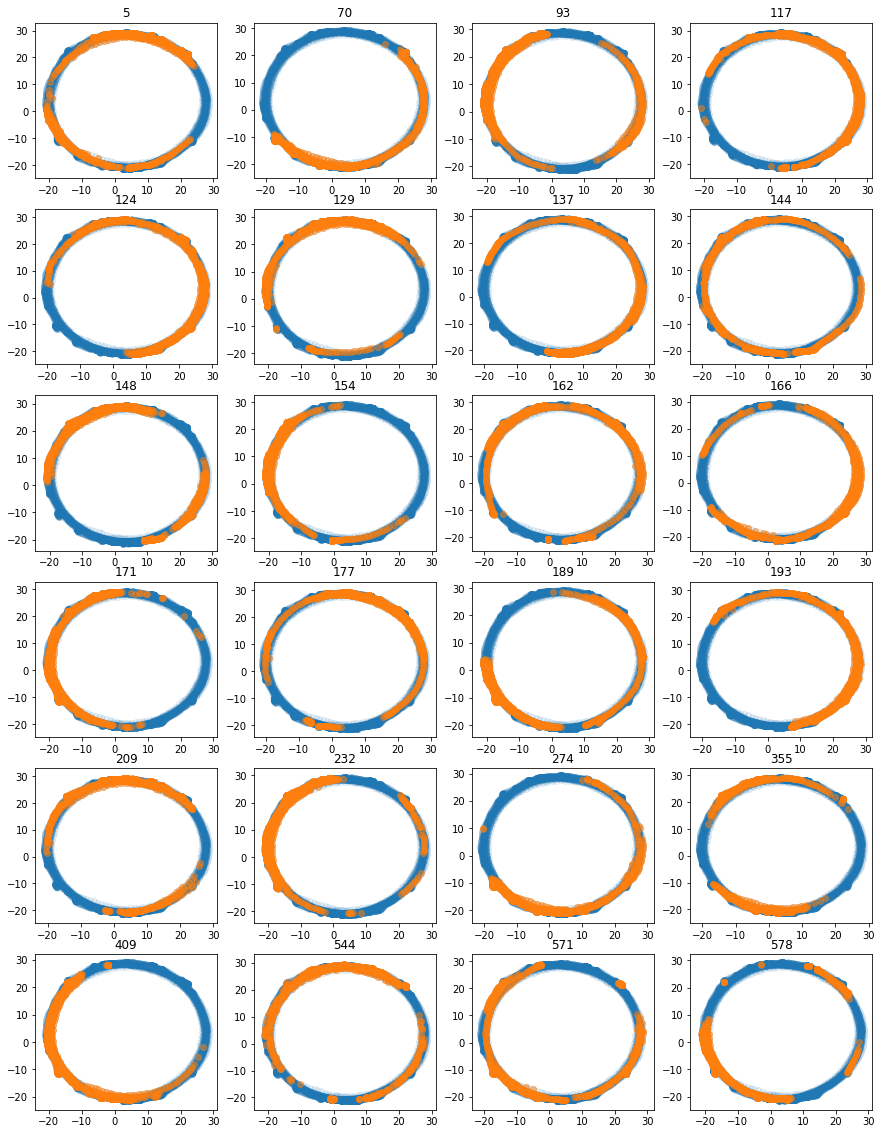

In [64]:
n = len(full_data)
new_data = full_data#.iloc[n // 2:]

quantiles = new_data[best_columns + 1].quantile(0.85)

plt.figure(figsize=(15, 20))
# plt.suptitle('Manualy selected neurons')

for i, col in enumerate(best_columns + 1):
    plt.subplot(6, 4, i + 1)
    plt.title(col)
    
    quantile = quantiles[col]
    active_state = (new_data[col] > quantile).values
    plt.scatter(new_data['x'], new_data['y'], alpha=0.1)
    plt.scatter(new_data[active_state].x, new_data[active_state].y, alpha=.5)
# plt.fig('Manualy selected neurons')

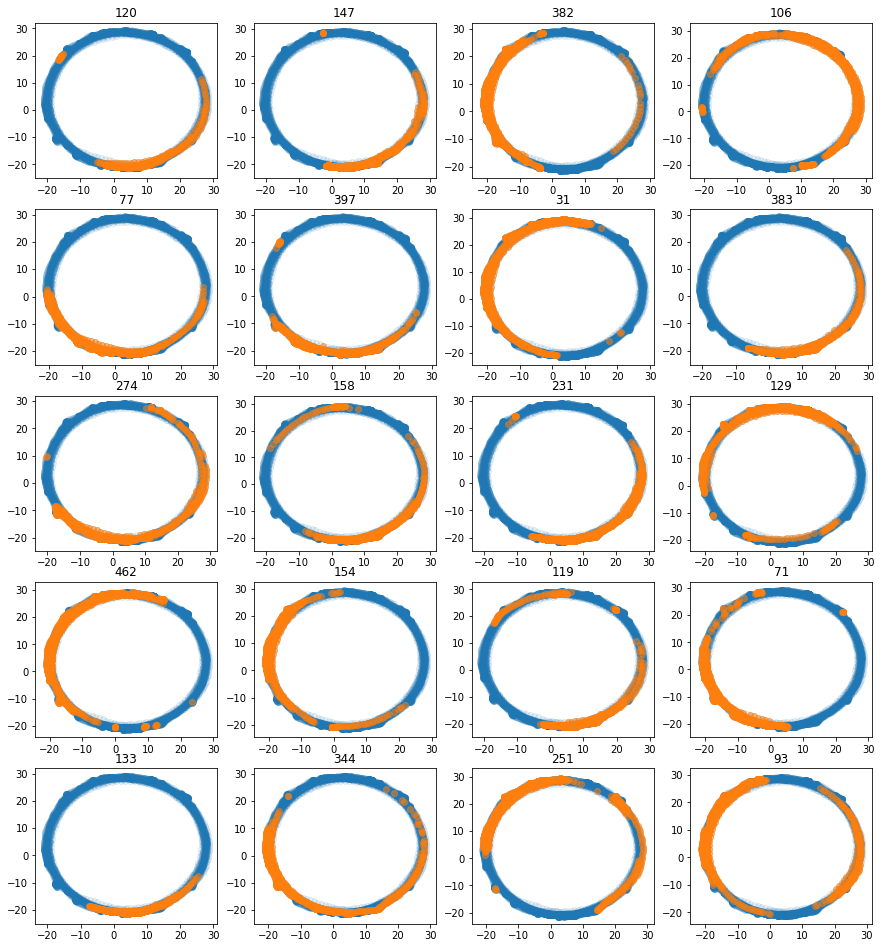

In [69]:
n = len(full_data)
new_data = full_data#.iloc[n // 2:]

quantiles = new_data[cols].quantile(0.85)

plt.figure(figsize=(15, 20))

for i, col in enumerate(cols):
    plt.subplot(6, 4, i + 1)
    plt.title(col)
    
    quantile = quantiles[col]
    active_state = (new_data[col] > quantile).values
    plt.scatter(new_data['x'], new_data['y'], alpha=0.1)
    plt.scatter(new_data[active_state].x, new_data[active_state].y, alpha=.5)
# plt.title('Best MI neurons')

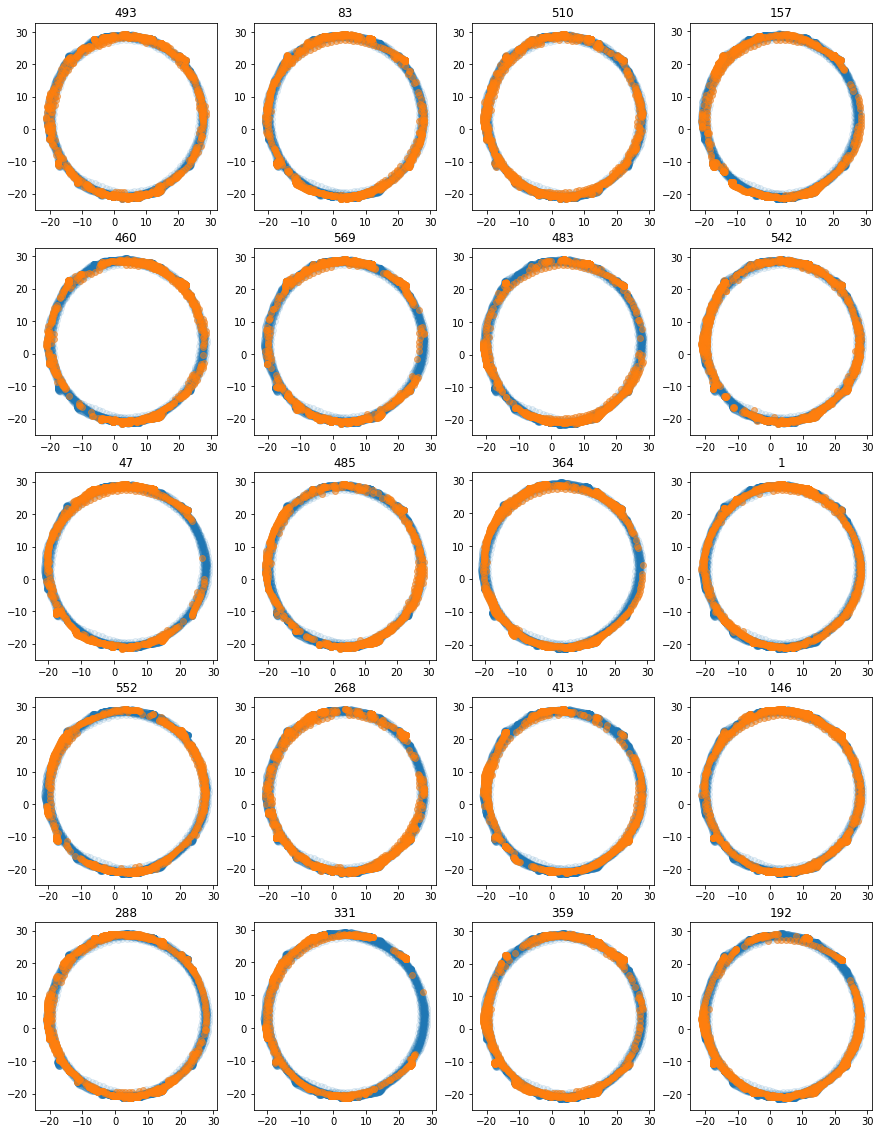

In [70]:
worst_cols = [col for col, _ in sorted(mis.items(), key=lambda x: x[1])][:20]

n = len(full_data)
new_data = full_data#.iloc[n // 2:]

quantiles = new_data[worst_cols].quantile(0.85)

plt.figure(figsize=(15, 20))

for i, col in enumerate(worst_cols):
    plt.subplot(5, 4, i + 1)
    plt.title(col)
    
    quantile = quantiles[col]
    active_state = (new_data[col] > quantile).values
    plt.scatter(new_data['x'], new_data['y'], alpha=0.1)
    plt.scatter(new_data[active_state].x, new_data[active_state].y, alpha=.5)
# plt.title('Worst MI neurons')

In [71]:
bad_cols = [129, 119, 93, 382]
new_cols = list(set(cols) - set(bad_cols))

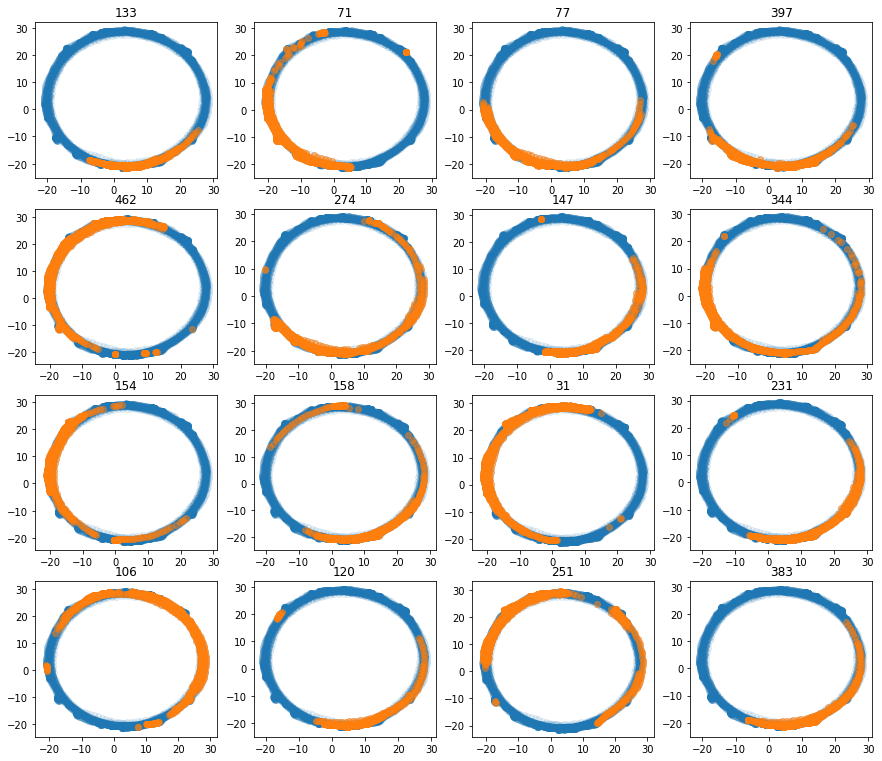

In [73]:
n = len(full_data)
new_data = full_data#.iloc[n // 2:]

quantiles = new_data[cols].quantile(0.85)

plt.figure(figsize=(15, 20))

for i, col in enumerate(set(cols) - set(bad_cols)):
    plt.subplot(6, 4, i + 1)
    plt.title(col)
    
    quantile = quantiles[col]
    active_state = (new_data[col] > quantile).values
    plt.scatter(new_data['x'], new_data['y'], alpha=0.1)
    plt.scatter(new_data[active_state].x, new_data[active_state].y, alpha=.5)
# plt.title('Neurons with single-linked active area')

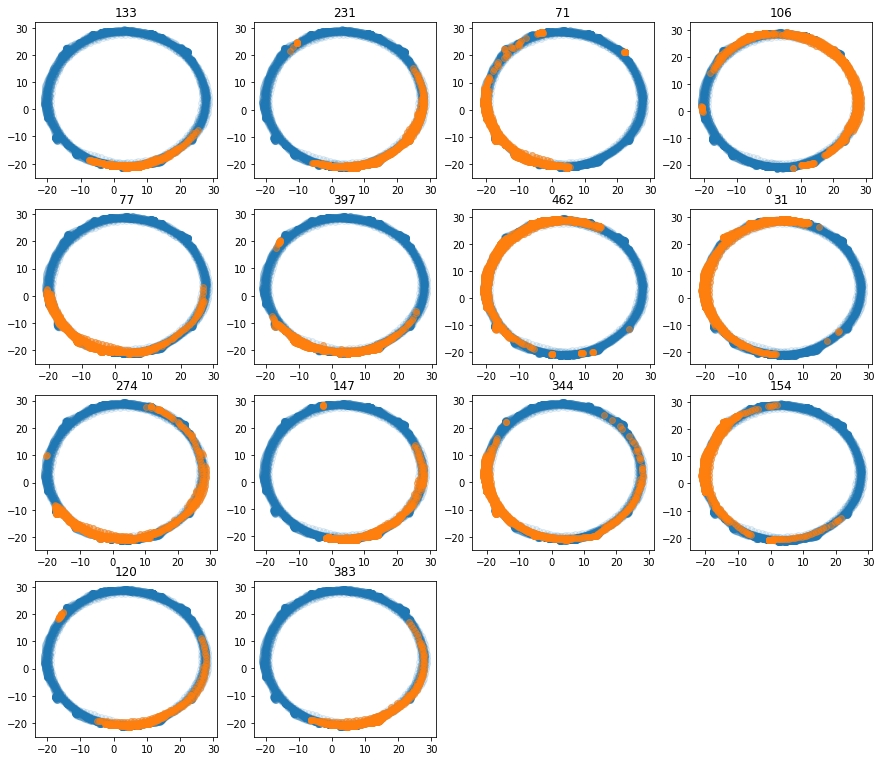

In [186]:
n = len(full_data)
new_data = full_data#.iloc[n // 2:]

quantiles = new_data[cols].quantile(0.85)

plt.figure(figsize=(15, 20))

for i, col in enumerate(set(cols) - set(bad_cols + [158, 251])):
    plt.subplot(6, 4, i + 1)
    plt.title(col)
    
    quantile = quantiles[col]
    active_state = (new_data[col] > quantile).values
    plt.scatter(new_data['x'], new_data['y'], alpha=0.1)
    plt.scatter(new_data[active_state].x, new_data[active_state].y, alpha=.5)
# plt.title('Neurons with single-linked active area')

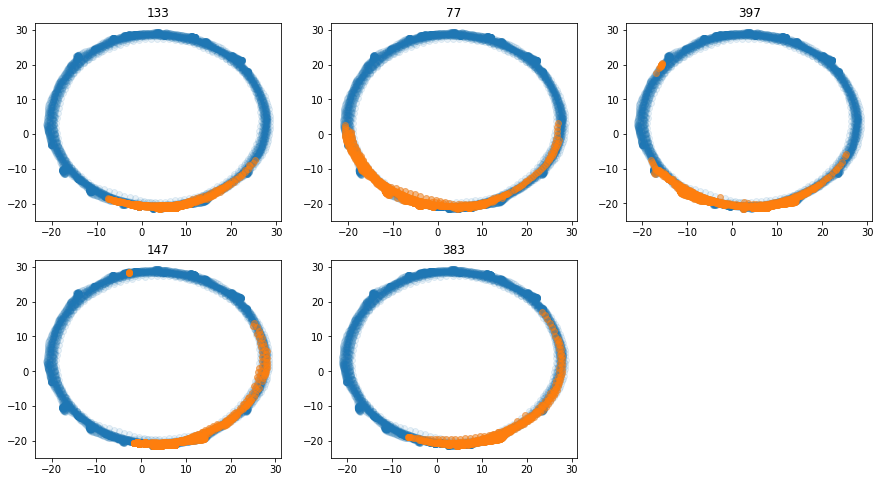

In [77]:
one_side_neurons = [133, 77, 397, 147, 383]

n = len(full_data)
new_data = full_data#.iloc[n // 2:]

quantiles = new_data[one_side_neurons].quantile(0.85)

plt.figure(figsize=(15, 8))

for i, col in enumerate(one_side_neurons):
    plt.subplot(2, 3, i + 1)
    plt.title(col)
    
    quantile = quantiles[col]
    active_state = (new_data[col] > quantile).values
    plt.scatter(new_data['x'], new_data['y'], alpha=0.1)
    plt.scatter(new_data[active_state].x, new_data[active_state].y, alpha=.5)
# plt.title('Neurons with single-linked active area')

In [27]:
n = full_data.shape[0]
train_size = 0.7
train, test = full_data.loc[:train_size * n], full_data.loc[train_size * n:]

In [28]:
X_train, y_train, X_test, y_test = train[cols], get_y(train[y_cols]), test[cols], get_y(test[y_cols])

In [29]:
def get_y_float(y, n=10):
    return (np.angle((y.x + 1j * y.y).values) + np.pi) / 2 / np.pi * 10

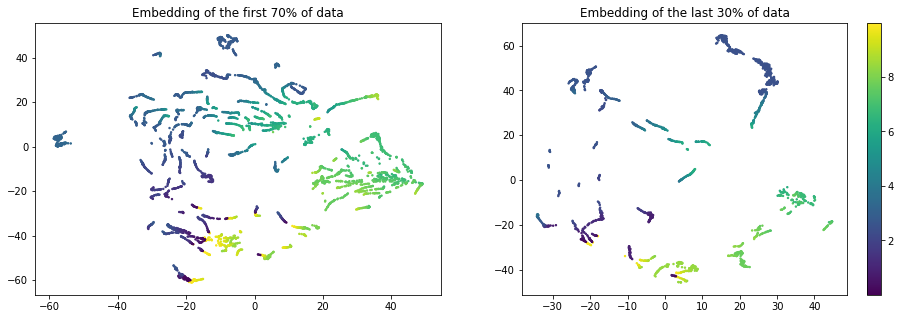

In [54]:
np.random.seed(43)
X_embedded = TSNE(n_components=2, perplexity=100).fit_transform(full_data[cols])
m = len(X_embedded)
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.scatter(X_embedded[:int(0.7*m), 0], X_embedded[:int(0.7*m), 1], s=2, c=get_y_float(full_data)[:int(0.7*m)])
plt.title('Embedding of the first 70% of data')
plt.subplot(1, 2, 2)
plt.scatter(X_embedded[int(0.7*m):, 0], X_embedded[int(0.7*m):, 1], s=2, c=get_y_float(full_data)[int(0.7*m):])
plt.title('Embedding of the last 30% of data')
plt.colorbar()

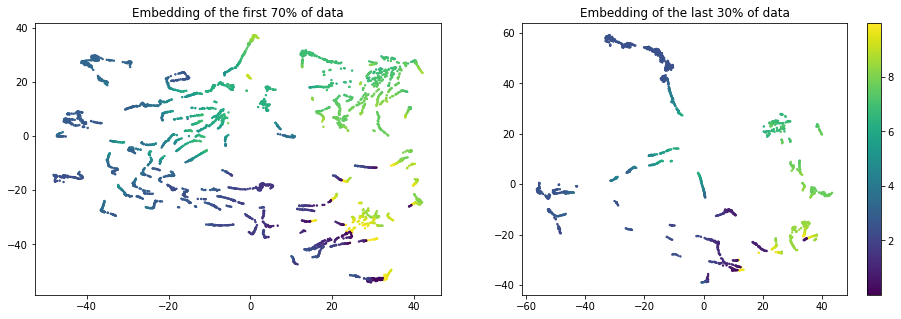

In [55]:
new_cols = list(set(cols) - set(bad_cols))
np.random.seed(42)
X_embedded = TSNE(n_components=2, perplexity=100).fit_transform(full_data[cols])
m = len(X_embedded)
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.scatter(X_embedded[:int(0.7*m), 0], X_embedded[:int(0.7*m), 1], s=2, c=get_y_float(full_data)[:int(0.7*m)])
plt.title('Embedding of the first 70% of data')
plt.subplot(1, 2, 2)
plt.scatter(X_embedded[int(0.7*m):, 0], X_embedded[int(0.7*m):, 1], s=2, c=get_y_float(full_data)[int(0.7*m):])
plt.title('Embedding of the last 30% of data')
plt.colorbar()

In [56]:
get_y_float(full_data)[int(0.7*m):]

array([7.86003162, 7.89753934, 7.93850973, ..., 7.68772837, 7.73210717,
       7.77729972])

In [57]:
cls = CatBoostClassifier(iterations=100, loss_function='MultiClass', eval_metric='Accuracy')
cls.fit(X_train, y_train)

0:	learn: 0.6541793	total: 115ms	remaining: 11.3s
1:	learn: 0.6974947	total: 164ms	remaining: 8.04s
2:	learn: 0.6904706	total: 212ms	remaining: 6.85s
3:	learn: 0.7190354	total: 259ms	remaining: 6.22s
4:	learn: 0.7265277	total: 307ms	remaining: 5.84s
5:	learn: 0.7340201	total: 354ms	remaining: 5.54s
6:	learn: 0.7368298	total: 401ms	remaining: 5.33s
7:	learn: 0.7614142	total: 449ms	remaining: 5.16s
8:	learn: 0.7639897	total: 497ms	remaining: 5.03s
9:	learn: 0.7712480	total: 546ms	remaining: 4.92s
10:	learn: 0.7714821	total: 594ms	remaining: 4.8s
11:	learn: 0.7738235	total: 641ms	remaining: 4.7s
12:	learn: 0.7728869	total: 688ms	remaining: 4.61s
13:	learn: 0.7794428	total: 736ms	remaining: 4.52s
14:	learn: 0.7876376	total: 784ms	remaining: 4.44s
15:	learn: 0.7871693	total: 832ms	remaining: 4.37s
16:	learn: 0.7918520	total: 881ms	remaining: 4.3s
17:	learn: 0.7930227	total: 928ms	remaining: 4.23s
18:	learn: 0.7958324	total: 976ms	remaining: 4.16s
19:	learn: 0.8007492	total: 1.02s	remaining:

In [58]:
def best_constant_answer(y, metric):
    max_acc = 0
    max_y = 0
    for i in np.unique(y):
        y_pred = np.ones(len(y)) * i
        acc = metric(y_pred, y)
        if acc > max_acc:
            max_acc, max_y = acc, y_pred
    return max_y

In [59]:
y_preds = [
    (cls.predict(X_test).reshape(-1), 'GBDT'),
    (np.random.choice(y_train, len(y_test)), 'Random from train distribution'),
    (np.random.choice(y_test, len(y_test)), 'Random from test distribution'),
    (best_constant_answer(y_test, acc_1), 'Best constant answer'),
]

pd.DataFrame([
    [name, acc_1(y_pred, y_test), acc_3(y_pred, y_test)]
    for y_pred, name in y_preds
], columns=['Name', '1-accuracy', '3-accuracy']).set_index('Name')

,1-accuracy,3-accuracy
Name,,
GBDT,0.606291,0.974512
Random from train distribution,0.131236,0.335683
Random from test distribution,0.183297,0.345987
Best constant answer,0.368221,0.503254


In [60]:
explainer = shap.TreeExplainer(cls)
shap_values = explainer.shap_values(X_test)

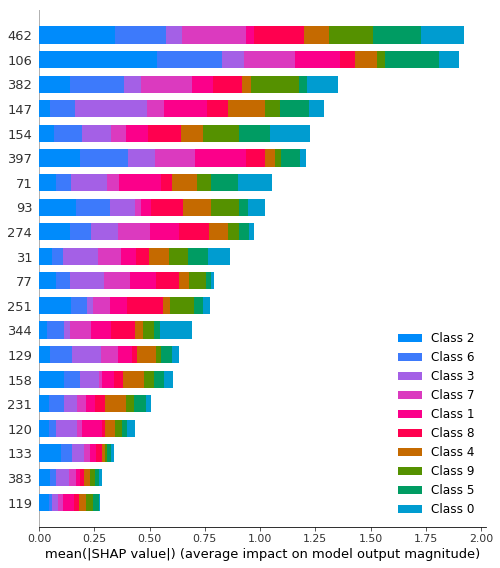

In [61]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [28]:
from sklearn.preprocessing import quantile_transform

In [29]:
set(cols) - set(new_cols)

NameError: name 'new_cols' is not defined

In [31]:
data = quantile_transform(full_data[cols])
new_data = quantile_transform(full_data[new_cols])
y = full_data[y_cols]

The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`


In [35]:
from dionysus import Filtration, homology_persistence, init_diagrams, Simplex
from collections import Counter
#from hamming_diagrams import get_cycles

In [36]:
def get_all_subsets(arr):
    n = len(arr)
    for i in range(1, 2**n):
        a = (np.array(list(reversed(bin(int(i))[2:]))) == '1')
        a.resize(n)
        yield tuple(arr[a].tolist())

In [37]:
def get_cycles(filtration, end_time=np.inf):
    m = homology_persistence(filtration, prime=2)
    dgms = init_diagrams(m, filtration)
    cycles = []
    for i, dgm in enumerate(dgms):
        for pt in dgm:
            cycles.append((i, pt.birth, pt.death))
    cycles = pd.DataFrame(cycles, columns=['dimension', 'birth_time', 'death_time'])
    cycles['living_time'] = cycles['death_time'] - cycles['birth_time']
    inf_life = (cycles['living_time'] == np.inf)
    cycles['living_time'][inf_life] = end_time - cycles['birth_time'][inf_life]
    return cycles.sort_values('living_time', ascending=False)

In [40]:
def construct_cycles(data):
    all_cycles = []
    for common_sec in np.arange(5, 0.9, -1):
        common_cnt = common_sec * 10
        filtration = Filtration()
        arr = set()
        for alpha in np.arange(0.95, 0.5, -0.01):
            neuron_activity = (data > alpha)
            sims = np.sum(neuron_activity * 2**np.arange(neuron_activity.shape[1]), axis=1)
            c = Counter(sims)
            sims = []
            for sim, cnt in c.items():
                if cnt > common_cnt:
                    sims.append(np.where(np.array(list(reversed(bin(int(sim))[2:]))) == '1')[0])

            cur_arr = []
            for sim in sims:
                for s in get_all_subsets(sim):
                    cur_arr.append(s)

            cur_arr = sorted(list(set(cur_arr) - arr), key=lambda x: len(x))
            for sim in cur_arr:
                filtration.append(Simplex(sim, 1 - alpha))
        print(filtration)
        cycles = get_cycles(filtration, 0.5)
        cycles.columns = ['%s_%.2f' % (col, float(common_cnt) / len(data) * 100) for col in cycles.columns]
        all_cycles.append(cycles)
    
    df = all_cycles[0].reset_index(drop=True)
    for i, c in enumerate(all_cycles[1:]):
        df = df.join(c.reset_index(drop=True), how='outer')
    return all_cycles, df

In [41]:
len(mis.items())

590

In [43]:
worst_cols = [col for col, _ in sorted(mis.items(), key=lambda x: x[1])][:60]
worst_data = quantile_transform(full_data[cols])

construct_cycles(worst_data)[1].T

The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Filtration with 1051 simplices
Filtration with 4528 simplices
Filtration with 8067 simplices
Filtration with 13643 simplices
Filtration with 62645 simplices


,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,111
dimension_0.82,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
birth_time_0.82,0.05,0.30,0.31,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
death_time_0.82,inf,inf,inf,0.18,0.18,0.13,0.13,0.12,0.12,0.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
living_time_0.82,0.45,0.20,0.19,0.13,0.13,0.08,0.08,0.07,0.07,0.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dimension_0.65,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
birth_time_0.65,0.05,0.23,0.28,0.09,0.21,0.05,0.05,0.05,0.12,0.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
death_time_0.65,inf,inf,0.47,0.17,0.28,0.11,0.09,0.09,0.16,0.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
living_time_0.65,0.45,0.27,0.19,0.08,0.07,0.06,0.04,0.04,0.04,0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dimension_0.49,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
birth_time_0.49,0.05,0.13,0.11,0.19,0.34,0.07,0.05,0.12,0.06,0.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
worst_data = quantile_transform(full_data[one_side_neurons])

construct_cycles(worst_data)[1].T

/home/robdrynkin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,0,1,2,3,4,5,6,7,8,9,10
dimension_0.82,0.00,1.00,1.00,2.00,0.00,1.00,0.00,0.00,2.00,3.00,NaN
birth_time_0.82,0.05,0.10,0.07,0.21,0.05,0.11,0.05,0.05,0.23,0.30,NaN
death_time_0.82,inf,0.21,0.17,0.26,0.09,0.14,0.07,0.06,0.24,0.31,NaN
living_time_0.82,0.45,0.11,0.10,0.05,0.04,0.03,0.02,0.01,0.01,0.01,NaN
dimension_0.65,0.00,1.00,1.00,1.00,2.00,0.00,3.00,2.00,0.00,1.00,NaN
birth_time_0.65,0.05,0.09,0.07,0.09,0.20,0.05,0.27,0.22,0.05,0.15,NaN
death_time_0.65,inf,0.20,0.15,0.14,0.25,0.08,0.29,0.23,0.06,0.16,NaN
living_time_0.65,0.45,0.11,0.08,0.05,0.05,0.03,0.02,0.01,0.01,0.01,NaN
dimension_0.49,0.00,1.00,1.00,2.00,1.00,1.00,1.00,3.00,0.00,1.00,2.00
birth_time_0.49,0.05,0.09,0.05,0.19,0.13,0.09,0.07,0.25,0.05,0.13,0.20


In [ ]:
def to_str(x):
    if isinstance(x, int):
        return str(x)
    else:
        return "%.2f" % x

for x in df:
    o = df[x]
    print(x + ' & ' + ' & '.join([to_str(a) for a in o][:12]) + ' \\\\')
#     print(int(o['dimension']), o['birth_time'], o['death_time'], o['living_time'])

In [80]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

In [180]:
def plot_cycles(all_cycles):
    c_map = {
        0: 'blue',
        1: 'red',
        2: 'green',
        3: 'black',
        4: 'yellow'
    }


    # legend_elements = [mpatches.Patch(color=c, edgecolor='#000000') for c, d in c_map.items()]

    plt.figure(figsize=(15, 7))
    
    for i, cycles in enumerate(all_cycles):
        plt.subplot(2, 3, i + 1)
        
        if i == 0:
            for d, c in c_map.items():
                plt.scatter([-1], [-1], c=c, label=f'dim={d}')
        
        x = cycles.values
        x[x == np.inf] = 0.5
        plt.scatter(x[:, 1], x[:, 2], c=[c_map[y] for y in x[:, 0]])
    #     for x in cycles.values:
    #         x[x == np.inf] = 0.5
    #         plt.plot([x[1], x[1]], [x[1], x[2]], c=c_map[x[0]], markersize=3, marker='o')
        q = np.arange(0.0, 0.6, 0.01)
        plt.plot(t, t, '--', c='grey')
        plt.xlabel('Birth time')
        plt.ylabel('Death time')
        plt.xlim(0, 0.6)
        plt.ylim(0, 0.6)
#         plt.xscale(0.5)
#         plt.yscale(0.5)

    # plt.subplot(2, 3, 6)
    # plt.legend(legend_elements)
    legend_elements = [Line2D([0], [0], c=c, label=f'dim = {d}') for d, c in c_map.items()]
#     print(c_map.items(), legend_elements)
            
#     plt.figlegend(legend_elements, labels=[f'dim={i}' for i in range(5)], loc = 'lower center', ncol=5, labelspacing=0. )
    plt.figlegend(loc='lower right', bbox_to_anchor=(0.75, 0.15))
    # plt.legend(handles=legend_elements)

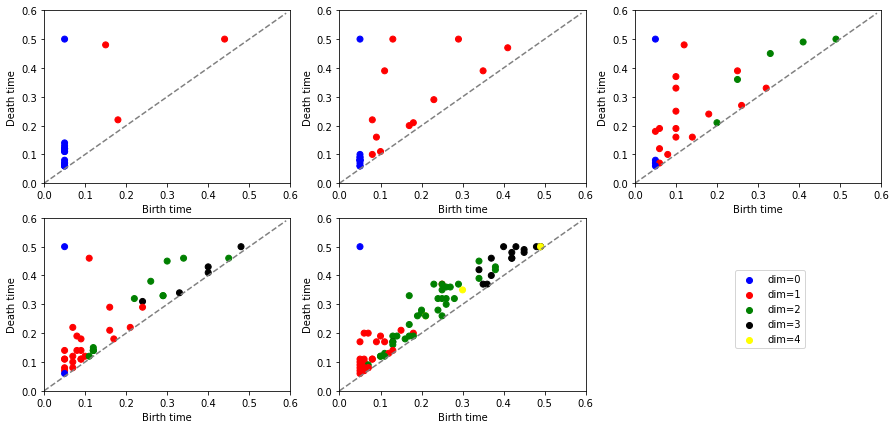

In [181]:
plot_cycles(all_cycles_1)

/home/robdrynkin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/robdrynkin/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


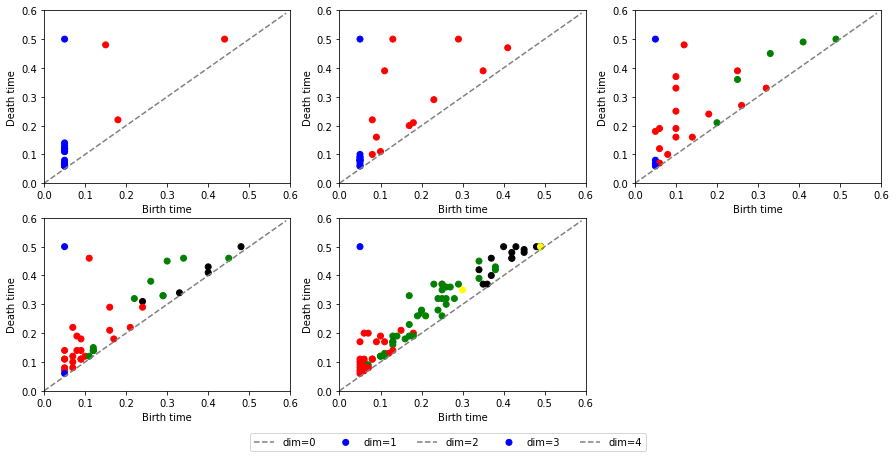

In [136]:
new_data = quantile_transform(full_data[new_cols])
all_cycles_1, df_1 = construct_cycles(new_data)
plot_cycles(all_cycles_1)

/home/robdrynkin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


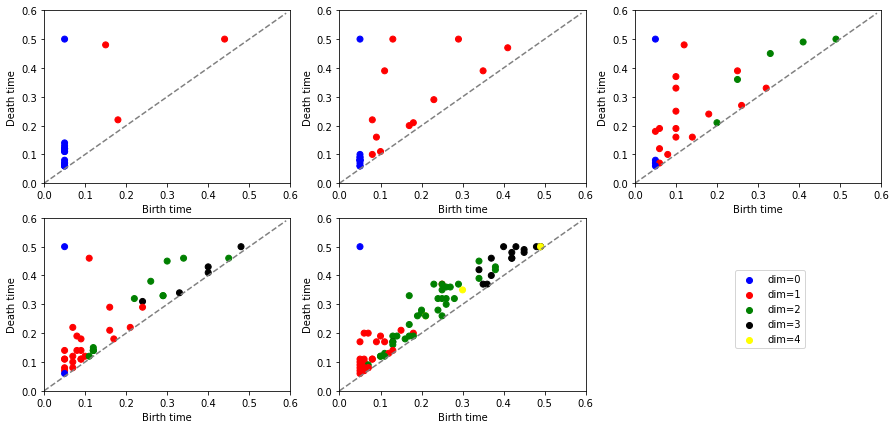

In [194]:
new_data = quantile_transform(full_data[list(set(cols) - set(bad_cols + [158, 251, 120]))])
all_cycles_3, df_3 = construct_cycles(new_data)
plot_cycles(all_cycles_1)

/home/robdrynkin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


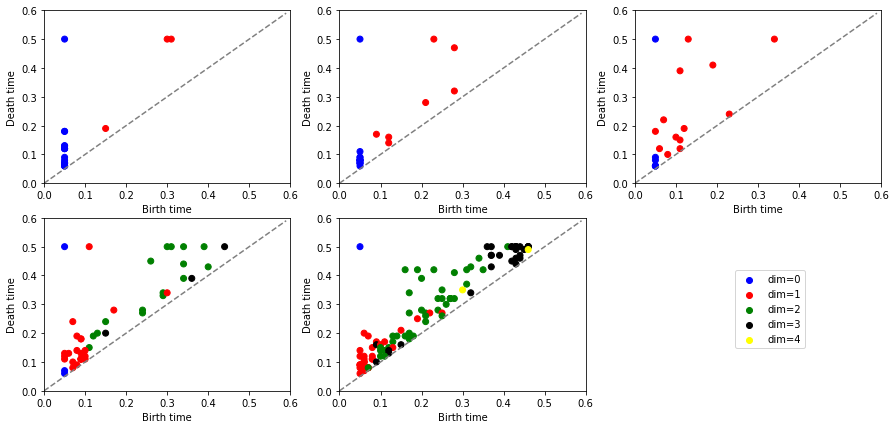

In [182]:
new_data = quantile_transform(full_data[cols])
all_cycles_2, df_2 = construct_cycles(new_data)
plot_cycles(all_cycles_2)

In [139]:
df_2.T

,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,111
dimension_0.82,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
birth_time_0.82,0.05,0.30,0.31,0.05,0.05,0.05,0.05,0.05,0.05,0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
death_time_0.82,inf,inf,inf,0.18,0.18,0.13,0.13,0.12,0.12,0.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
living_time_0.82,0.45,0.20,0.19,0.13,0.13,0.08,0.08,0.07,0.07,0.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dimension_0.65,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
birth_time_0.65,0.05,0.23,0.28,0.09,0.21,0.05,0.05,0.05,0.12,0.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
death_time_0.65,inf,inf,0.47,0.17,0.28,0.11,0.09,0.09,0.16,0.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
living_time_0.65,0.45,0.27,0.19,0.08,0.07,0.06,0.04,0.04,0.04,0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dimension_0.49,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
birth_time_0.49,0.05,0.13,0.11,0.19,0.34,0.07,0.05,0.12,0.06,0.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
for x in df:
    o = df[x]
    print(x + ' & ' + ' & '.join([to_str(a) for a in o][:9]) + ' \\\\')

dimension_0.82 & 0.00 & 1.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 1.00 & 0.00 \\
birth_time_0.82 & 0.05 & 0.15 & 0.05 & 0.05 & 0.05 & 0.05 & 0.05 & 0.44 & 0.05 \\
death_time_0.82 & inf & 0.48 & 0.14 & 0.13 & 0.12 & 0.12 & 0.12 & inf & 0.11 \\
living_time_0.82 & 0.45 & 0.33 & 0.09 & 0.08 & 0.07 & 0.07 & 0.07 & 0.06 & 0.06 \\
dimension_0.65 & 0.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 0.00 \\
birth_time_0.65 & 0.05 & 0.13 & 0.11 & 0.29 & 0.08 & 0.09 & 0.41 & 0.23 & 0.05 \\
death_time_0.65 & inf & inf & 0.39 & inf & 0.22 & 0.16 & 0.47 & 0.29 & 0.10 \\
living_time_0.65 & 0.45 & 0.37 & 0.28 & 0.21 & 0.14 & 0.07 & 0.06 & 0.06 & 0.05 \\
dimension_0.49 & 0.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 2.00 \\
birth_time_0.49 & 0.05 & 0.12 & 0.10 & 0.10 & 0.10 & 0.25 & 0.05 & 0.06 & 0.33 \\
death_time_0.49 & inf & 0.48 & 0.37 & 0.33 & 0.25 & 0.39 & 0.18 & 0.19 & 0.45 \\
living_time_0.49 & 0.45 & 0.36 & 0.27 & 0.23 & 0.15 & 0.14 & 0.13 & 0.13 & 0.12 \\
dimension_0.33 & 0.00 